Baroclinic Potential Vorticity Analysis, Divergence, and Winds
==============================================================

Classic baroclinic potential vorticity plot at 250 hPa using GFS
analysis file.

This example uses example data from the GFS analysis for 12 UTC 31
October 2016 and uses xarray as the main read source with using MetPy to
calculate the baroclinic potential vorticity, divergence and wind speed
with geographic plotting using Cartopy for a CONUS view of the 250-hPa
surface with divergence and wind barbs.

By: Kevin Goebbert

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
import xarray as xr

The following code reads the example data using the xarray open_dataset
function and prints the coordinate values that are associated with the
various variables contained within the file.

This code uses the metpy accessor to parse file to make it easy to pull
data using common coordinate names (e.g., vertical) and attach units.


In [2]:
ds = xr.open_dataset('https://thredds.ucar.edu/thredds/dodsC/'
                     'casestudies/python-gallery/GFS_20101026_1200.nc').metpy.parse_cf()

Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Could not find variable corresponding to the value of grid_mapping: LatLon_Projection
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Could not find variable corresponding to the value of grid_mapping: LatLon_Proje

Data Retrieval
--------------

This code retrieves the necessary data from the file and completes some
smoothing of the temperature, and wind fields using the MetPy function
smooth_n_point. A nicely formated valid time (vtime) variable is also
created.


In [3]:
# Set subset slice for the geographic extent of data to limit download
lon_slice = slice(200, 350)
lat_slice = slice(85, 10)

# Grab lat/lon values (GFS will be 1D)
lats = ds.lat.sel(lat=lat_slice).values
lons = ds.lon.sel(lon=lon_slice).values


# Grab the pressure levels and select the data to be imported
# Need all pressure levels for Temperatures, U and V Wind, and Rel. Humidity
# Smooth with the gaussian filter from scipy
pres = ds['isobaric3'].values[:] * units('Pa')

tmpk_var = ds['Temperature_isobaric'].metpy.sel(lat=lat_slice, lon=lon_slice).squeeze()
tmpk = mpcalc.smooth_n_point(tmpk_var, 9, 2)
thta = mpcalc.potential_temperature(pres[:, None, None], tmpk)

uwnd_var = ds['u-component_of_wind_isobaric'].metpy.sel(lat=lat_slice, lon=lon_slice).squeeze()
vwnd_var = ds['v-component_of_wind_isobaric'].metpy.sel(lat=lat_slice, lon=lon_slice).squeeze()
uwnd = mpcalc.smooth_n_point(uwnd_var, 9, 2)
vwnd = mpcalc.smooth_n_point(vwnd_var, 9, 2)

# Create a clean datetime object for plotting based on time of Geopotential heights
vtime = ds.time.data[0].astype('datetime64[ms]').astype('O')

Use MetPy to compute the baroclinic potential vorticity on all isobaric
levels and other variables


In [4]:
# Compute dx and dy spacing for use in vorticity calculation
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

# Comput the PV on all isobaric surfaces
pv = mpcalc.potential_vorticity_baroclinic(thta, pres[:, None, None], uwnd, vwnd,
                                           dx[None, :, :], dy[None, :, :],
                                           lats[None, :, None] * units('degrees'))

# Use MetPy to compute the divergence on the pressure surfaces
div = mpcalc.divergence(uwnd, vwnd, dx[None, :, :], dy[None, :, :], dim_order='yx')

# Find the index value for the 250-hPa surface
i250 = list(pres.m).index(((250 * units('hPa')).to(pres.units)).m)

Map Creation
------------

This next set of code creates the plot and draws contours on a Lambert
Conformal map centered on -100 E longitude. The main view is over the
CONUS with isobaric PV map with PV contoured every 1 PVU and divergence
colorshaded.


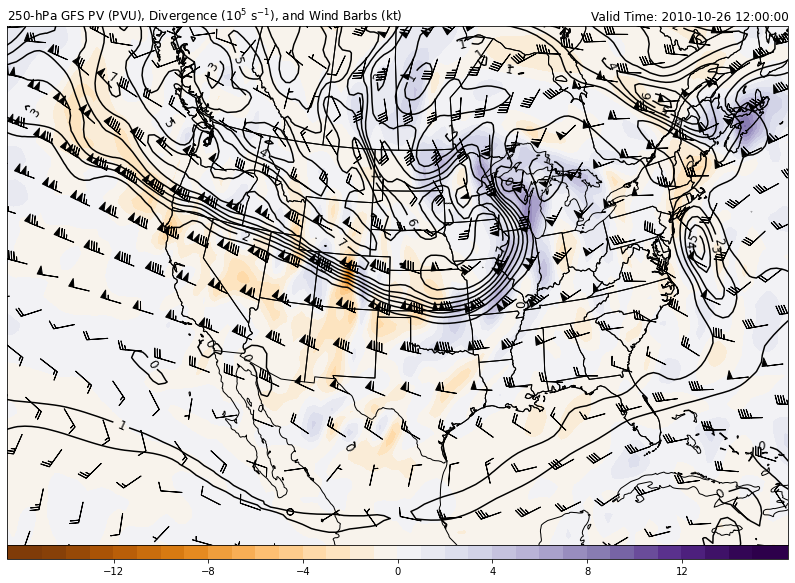

In [5]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.LambertConformal(central_longitude=-100, central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot the contours of PV at 250 hPa, scaling 10^6 every 1 PVU
clevs_pv = np.arange(0, 25, 1)
cs1 = ax.contour(lons, lats, pv[i250]*1e6, clevs_pv, colors='black',
                 transform=datacrs)
plt.clabel(cs1, fmt='%d', fontsize='large')

# Plot the colorfill of divergence, scaled 10^5 every 1 s^1
clevs_div = np.arange(-15, 16, 1)
cs1 = ax.contourf(lons, lats, div[i250]*1e5, clevs_div, cmap=plt.cm.PuOr,
                  extend='both', transform=datacrs)
plt.colorbar(cs1, orientation='horizontal', pad=0, aspect=50, extendrect=True)

# Plot the wind barbs at 250 hPa
wind_slice = slice(None, None, 6)
ax.barbs(lons[wind_slice], lats[wind_slice],
         uwnd[i250][wind_slice, wind_slice].to('kt').m,
         vwnd[i250][wind_slice, wind_slice].to('kt').m, pivot='middle',
         color='black', length=6.5, transform=datacrs)

# Plot some titles to tell people what is on the map
plt.title('250-hPa GFS PV (PVU), Divergence ($10^5$ s$^{-1}$),'
          ' and Wind Barbs (kt)', loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right');